# TP Coding Convolutional Neural Networks in Pytorch - part 2

Author : Alasdair Newson

alasdair.newson@telecom-paris.fr

In this session, we shall be looking at two subjects :

- A way to visualise what networks are learning : the Deep Dream algorithm
- Adversarial examples

At the heart of these two applications is the calculation of the gradient of a loss function with respect to the image itself (instead of respect to the weights). The loss function will be defined depending on the application at hand.

We shall use a pre-trained, well-known pretrained network. The lab has been designed for the VGG19 architecture. You can try with other networks, but bear in mind that the pre-processing operations are different for each network, so you would have to change the code correspondingly.

First, let's load the necessary packages.

In [ ]:
import numpy as np
import torch
import torch.nn as nn
from torchvision import transforms
import torchvision.models as models
from torch.autograd import Variable

from PIL import Image, ImageFilter, ImageChops
import matplotlib.pyplot as plt
import PIL

using_colab=True

Now, let's load one of the most famous networks, VGG16 or inceptionv3 (you choose), and view it's architecture with the eval() function.

In [ ]:

model_name = 'vgg19'

vgg_model = models.vgg19(pretrained=True)
vgg_model.eval()


/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

You can visualise the weights if you like in a similar manner to the first part of the TP.

## 2. Deep Dream

We now proceed to carry out the Deep Dream algorithm. The idea of the Deep Dream algorithm is to find an image which maximises the response of a network at a certain layer : $\textbf{this should help us understand what the network is learning}$. This can be done with an iterative algorithm, by simply carrying out gradient $\textbf{ascension}$. We start with an input image and iteratively add the gradient of the average response of the features which interest us. A pseudo-code for this would be :

- img = img_in
- for i=1:n_iters
    - img = img + grad_step $\nabla_{img} \mathcal{L}$,
    
where $\mathcal{L}$ is a function of the responses which interest us (you need to define this). In this part of the lab, we shall use the average squared response.

Let's first define a function to preprocess the image. This is needed to put the image in the correct format for the VGG19 network. We also create a function to invert this process. You can add cases for other networks if you wish (and you can get it working :) ).

In [ ]:
normalise_resize = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # normalisation
])

def format_image(img_file):
	"""
	This function reads and formats an image so that it can be fed to the VGG16 networks
	
	Parameters
	----------
	img_file : image file name
	
	Returns
	-------
	img_out_model : the correctly formatted image for VGG16 or inceptionv3 networks
	img : the image as read by the load_img function of keras.preprocessing.image
	"""
	# read image
	img = PIL.Image.open(img_file)
	img_tensor = normalise_resize(img).unsqueeze(axis=0)
	img_np = np.array(img)
 
	return img_tensor, img_np

def unformat_image(img_in):
	"""
	This function inverts the preprocessing applied to images for use in the VGG16/inceptionv3 network
	
	Parameters
	----------
	img_file : formatted image of shape (batch_size,m,n,3)
	
	Returns
	-------
	img_out : a m-by-n-by-3 array, representing an image that can be written to an image file
	"""
	img_in = np.transpose(img_in.numpy().squeeze(),[1,2,0])
	# invert the mean and standard deviation
	mean = np.array([0.485, 0.456, 0.406]).reshape([1, 1, 3])
	std = np.array([0.229, 0.224, 0.225]).reshape([1, 1, 3])
	img_out = std * img_in + mean
	img_out *= 255
	img_out = np.uint8(np.clip(img_out, 0, 255))
	return img_out

Now, we load the image. ```format_image``` outputs two variables: the Pytorch tensor containing the image information, and a normal numpy array with this information, to visualise.

--2022-10-27 08:50:19--  https://perso.telecom-paristech.fr/anewson/doc/images/got.jpg
Resolving perso.telecom-paristech.fr (perso.telecom-paristech.fr)... 137.194.22.227, 2a04:8ec0:0:a::89c2:16e3
Connecting to perso.telecom-paristech.fr (perso.telecom-paristech.fr)|137.194.22.227|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 29707 (29K) [image/jpeg]
Saving to: ‘got.jpg.1’

got.jpg.1           100%[===================>]  29.01K  --.-KB/s    in 0s      

2022-10-27 08:50:19 (286 MB/s) - ‘got.jpg.1’ saved [29707/29707]



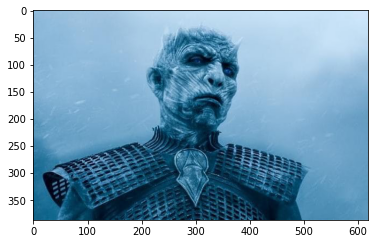

In [ ]:

#load image
if (using_colab == True):
    !wget "https://perso.telecom-paristech.fr/anewson/doc/images/got.jpg"
    img_in,img_np = format_image('got.jpg')
else:
    img_in,img_np = format_image('images/got.jpg')
#show the input image
plt.imshow(img_np)
plt.show()

Note: we have resized the image to be accepted as an input by VGG19. Strictly speaking, we do not actually have to do this, since we are only using the _convolutional_ part of VGG19 (and not the classification layer), but since we will be using the full network afterwards, we may as well take care of this resizing problem now. This is the resized image: 

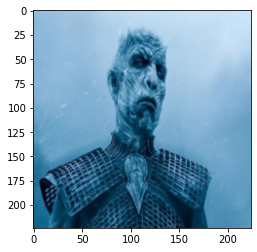

In [ ]:
plt.imshow(unformat_image(img_in))
plt.show()

## Deep dream gradient ascension

We will implement the following elements in a function named ```deep_dream_gradient_step```.

### Loss function (loss to _maximise_)
We need to define the loss that we wish to maximise. This can be anything you wish, but a common loss is simply the average squared response of certain layers. So, we loop over the layers of the network, and extract the responses at the layers which interest us. We take the average value of the squared responses as our loss.

### 2/ Gradient step

Next, we need to carry out one gradient step of the deep dream algorithm. To do this, we need the gradients of the loss with respect to the image. Pytorch allows one to do this quite easily.

Thus, _before_ defining the loop over the layers, we first create a Pytorch ```Variable``` from the input image, to which we can backpropagate the loss's gradient. This is done  with:

- ```y = Variable(x, requires_grad=True)```

The gradient is backpropagated to all elements contributing to this loss with:

- ```loss.backward()```

We can then extract the gradients from ```y``` with:

- ```y.grad.data```

Finally, we use a little trick. Indeed, it may be the case that the gradients are far too small or far too large for updating, meaning that the updates do nothing or destroy the image. To avoid this, we normalise the gradients, such that the standard deviation is 1.

- $\nabla = \frac{\nabla}{std(\nabla) + \epsilon}$

We also add a small constant $ɛ$ to avoid division by 0. Set this constant to 1e-8.

Fill in the following function which carries out a step of the gradient ascent.

In [ ]:


def deep_dream_gradient_step(img_in, model_in, layer_ids_to_use, step_size):
	epsilon = 10**(-8)
	mean = np.array([0.485, 0.456, 0.406]).reshape([3, 1, 1])
	std = np.array([0.229, 0.224, 0.225]).reshape([3, 1, 1])
	
	activations = []
	losses = []
	img_var = Variable(img_in, requires_grad=True) # FILL in student
	x = img_var
	# First, we fetch the activations/feature maps which we want to analyse, when applied to img_in
	for index, layer in enumerate(vgg_model.features):
		# apply the layers iteratively
		x = layer(x)  # FILL in student
		if index in set(layer_inds):
			activations.append(x) 
	
	# now loop over the layers which interest you and calculate the average squared response, and add this to the list of losses.
	for layer_activation in activations:
		#loss_f = nn.MSELoss()  #!!!!!
		loss_component = torch.mean(layer_activation) # FILL IN STUDENT. !!!!!
		losses.append(loss_component)

	final_loss = torch.mean(layer_activation)
	# carry out backpropagation
	final_loss.backward() # !!!!!!

	# get gradients of loss function with respect to the image
	grad = img_var.grad.data # FILL IN STUDENT

	# Normalize the gradients (make them have mean = 0 and std = 1)
	g_std = torch.std(grad)
	g_mean = torch.mean(grad)
  # FILL IN STUDENT
	grad_n = (grad-g_mean)/(g_std-epsilon) # FILL IN STUDENT

	# Update image using the calculated gradients (gradient ascent step)
	img_in.data +=  grad_n*step_size  # FILL IN STUDENT

	# We clamp the data to avoid going too far from the VGG normalisation
	img_in[0, :, :, :] = np.clip(img_in[0, :, :, :], -mean / std, (1 - mean) / std)
 
	return img_in, final_loss
	#END STUDENT CODE

We are now ready to carry out the Deep Dream algorithm using gradient ascent, yipee ! Iterate 'n_iterations' times, each time adding an epsilon of the gradient. 

In [ ]:
layer_inds = [21,22]   # use these layers as default

# first, reload image to make sure that we are not starting from a previous initialisation
if (using_colab == True):
	#!wget 'https://perso.telecom-paristech.fr/anewson/doc/images/got.jpg'
	img_in,_ = format_image('got.jpg')
else:
	img_in,_ = format_image('images/got.jpg')

step_size = 0.09 # Gradient ascent step size
n_iterations = 30  # Number of gradient ascent steps

img_out = unformat_image(torch.clone(img_in))
plt.figure(num=None, figsize=(10, 8))
plt.imshow(img_out)
plt.show()
#img_in, model_in, layer_ids_to_use, step_size
for ii in range(0,n_iterations):
	img_in, loss = deep_dream_gradient_step(img_in, vgg_model, layer_inds, step_size)
	if (ii%5==0):
		print(".", end='')
		img_out = unformat_image(torch.clone(img_in))
		plt.figure(num=None, figsize=(10, 8))
		plt.imshow(img_out)
		plt.show()
    #plt.imsave('img_out_'+str(ii).zfill(3)+'.png',img_out)"""
	

Output hidden; open in https://colab.research.google.com to view.

You can try different layers and see what the results are !

## 3. Adversarial examples

In this part of the lab work, we will explore the interesting case of adversarial examples. Adversarial examples are images which have been perturbed in a manner which __makes the network misclassify the image__.

There are many ways to do this, however we can use a similar approach to the one used above, that is to say, we will use a gradient maximisation approach. This consists in iteratively adding the gradient of a redefined loss with respect to the image, to the current image, in order to get a misclassified image.

This loss will simply be the element (class) of the output (distribution) of the network which we want to maximise.

First, let's reload another image

--2022-10-27 08:51:19--  https://perso.telecom-paristech.fr/anewson/doc/images/cat_small.png
Resolving perso.telecom-paristech.fr (perso.telecom-paristech.fr)... 137.194.22.227, 2a04:8ec0:0:a::89c2:16e3
Connecting to perso.telecom-paristech.fr (perso.telecom-paristech.fr)|137.194.22.227|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 160840 (157K) [image/png]
Saving to: ‘cat_small.png.3’

cat_small.png.3     100%[===================>] 157.07K   864KB/s    in 0.2s    

2022-10-27 08:51:20 (864 KB/s) - ‘cat_small.png.3’ saved [160840/160840]

torch.Size([1, 3, 224, 224])


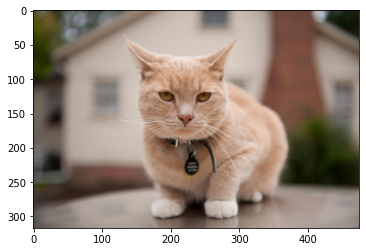

In [ ]:
if (using_colab == True):
    !wget "https://perso.telecom-paristech.fr/anewson/doc/images/cat_small.png"
    img_in,img_visu = format_image('cat_small.png')
else:
    img_in,img_visu = format_image('images/cat_small.png')

plt.imshow(img_visu)
print(img_in.shape)

If you look at the VGG19 architecture, we se that the output is a ```linear``` layer, so there is no non-linearity (although there should be a softmax). This is because Pytorch automatically carries out the softmax during training (we saw this in part 1).

Therefore, define again (as in part 1) a function called ```vector_to_class``` which converts a vector to a class.

In [ ]:
def vector_to_class(x):
  y = torch.argmax(torch.nn.Softmax()(x),axis=1)  # FILL IN STUDENT
  return y

We are going to try to force the image to recognise a 'reflex_camera'. This is number 759 of the imagenet classes. You can use any one you like in fact (apart from ones linked to cats, obviously). To see the list of classes go to :

https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a

First, we find the initial class of the cat image (which we consider to be the true class). Here, we have downloaded the imagenet label list to convert a class number to a string (name of the class).

In [ ]:
# get the image net class names
!wget "https://perso.telecom-paristech.fr/anewson/doc/data/image_net/imagenet1000_clsidx_to_labels.txt"
imagenet_labels = np.array(open("imagenet1000_clsidx_to_labels.txt").read().splitlines())

target_class = 759
# carry out the network predictions on the example image
#define the true class as the initial most likely class
true_class = ... # FILL IN STUDENT CODE
true_class_name = imagenet_labels[true_class]
print("True class : ", true_class_name)

--2022-10-27 08:51:21--  https://perso.telecom-paristech.fr/anewson/doc/data/image_net/imagenet1000_clsidx_to_labels.txt
Resolving perso.telecom-paristech.fr (perso.telecom-paristech.fr)... 137.194.22.227, 2a04:8ec0:0:a::89c2:16e3
Connecting to perso.telecom-paristech.fr (perso.telecom-paristech.fr)|137.194.22.227|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 30564 (30K) [text/plain]
Saving to: ‘imagenet1000_clsidx_to_labels.txt.2’

imagenet1000_clsidx 100%[===================>]  29.85K  --.-KB/s    in 0s      

2022-10-27 08:51:21 (159 MB/s) - ‘imagenet1000_clsidx_to_labels.txt.2’ saved [30564/30564]

True class :  ["{0: 'tench, Tinca tinca'," " 1: 'goldfish, Carassius auratus',"
 " 2: 'great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias',"
 " 3: 'tiger shark, Galeocerdo cuvieri',"
 " 4: 'hammerhead, hammerhead shark',"
 " 5: 'electric ray, crampfish, numbfish, torpedo'," " 6: 'stingray',"
 " 7: 'cock'," " 8: 'hen'," " 9: 'os

We must redefine the gradient step function for finding the adversarial example. It now takes the ```target_class``` instead of the list of layer indices to maximise. Therefore, note that you do not have to loop over all the layers, but simply take the output of the network.

Fill in the following function accordingly (you can use much of the previous code).

__IMPORTANT NOTE !!!__ : Remember that the output of the VGG (in Pytorch) is a linear layer, so a vector which is _not_ normalised to be a probability distribution. Therefore, you need to apply a ```torch.nn.Softmax()(.)``` to the output before calculating the loss (otherwise you will increase the target class without decreasing the other classes.

In [ ]:
def adversarial_example_gradient_step(img_in, model_in, target_class, step_size):

  # BEGIN STUDENT CODE
  epsilon = 1e-8
  mean = np.array([0.485, 0.456, 0.406]).reshape([3, 1, 1])
  std = np.array([0.229, 0.224, 0.225]).reshape([3, 1, 1])

  activations = []
  losses = []
  img_var = Variable(img_in, requires_grad=True) # FILL in student
  x = img_var

  output = model_in(x)

  target_class_torch = Variable(torch.LongTensor([target_class]), requires_grad=False) 


  criterion = torch.nn.CrossEntropyLoss()
  loss = criterion(output, target_class_torch)

  # carry out backpropagation
  loss.backward()

  # get gradients of loss function with respect to the image
  grad = img_var.grad.data # FILL IN STUDENT

  # Normalize the gradients (make them have mean = 0 and std = 1)
  g_std = torch.std(grad)
  g_mean = torch.mean(grad)
  

  grad_n = (grad-g_mean)/(g_std-epsilon)  # FILL IN STUDENT

  # Update image using the calculated gradients (gradient ascent step)
  img_in.data += -grad_n*step_size   # FILL IN STUDENT

  # We clamp the data to avoid going too far from the VGG normalisation
  img_in[0, :, :, :] = np.clip(img_in[0, :, :, :], -mean / std, (1 - mean) / std)

  # END STUDENT CODE
  return img_in, loss

We are now ready to perturb the image such that we misclassify it. Youhoo !

In [ ]:

# first, reload image to make sure that we are not starting from a previous initialisation
if (using_colab == True):
	img_in,_ = format_image('cat_small.png')
else:
	img_in,_ = format_image('images/cat_small.png')

step_size = 0.01 # Gradient ascent step size
n_iterations = 40  # Number of gradient ascent steps

current_class = int(vector_to_class(vgg_model(img_in))) # FILL IN STUDENT
current_class_name = imagenet_labels[current_class]

plt.figure(num=None, figsize=(10, 8))
img_out = unformat_image(torch.clone(img_in))
plt.imshow(img_out)
plt.show()
print("Current class : {} with probability : {:.4f}".format(current_class_name, torch.nn.Softmax()(vgg_model(img_in)[0,current_class])))
print(".", end='')

for ii in range(0,n_iterations):
  img_in, loss = adversarial_example_gradient_step(img_in, vgg_model, target_class, step_size) # FILL IN STUDENT

  if (ii%1==0):
    #get the current class
    current_class = int(vector_to_class(vgg_model(img_in))) # FILL IN STUDENT
    current_class_name = imagenet_labels[current_class]
    plt.figure(num=None, figsize=(10, 8))
    img_out = unformat_image(torch.clone(img_in))
    plt.imshow(img_out)
    plt.show()
    print("Current class : {} with probability : {:.4f}".format(current_class_name, torch.nn.Softmax()(vgg_model(img_in)[0,current_class])))
    print(".", end='')
    #plt.imsave('img_out_'+str(ii).zfill(3)+'.png',img_out)

img_out = unformat_image(torch.clone(img_in))
plt.figure(num=None, figsize=(10, 8))
plt.imshow(img_out)
plt.show()

Output hidden; open in https://colab.research.google.com to view.

As you should probably see, the image is changed such that it is no longer is correctly classified. It should be classified as a 'reflex camera', or whatever you chose, with high probability. This is a problem, since a human is still able to see a cat !

# Evaluation

To evaluate the work, you should rate the code for :
- 1) Deep dream, ```retrieve_weights``` function : 2 points
- 2) Deep dream, ```deep_dream_loss``` function : 1 point
- 3) Deep dream, ```gradient_step``` function : 2 points
- 4) Adversarial examples, choosing the right layer for the loss : 1 point
- 5) Adversarial examples, ```y_predicted```, ```true_class``` and ```y_predicted_decoded``` : 3 Points
- 6) Adversarial examples,  ```adversarial_loss``` function : 1 point

Total over 10 points.